<h1>ASSIGNMENT 3 : K-NN on Amazon Fine Food Reviews</h1>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

<strong> OBJECTIVES :</strong>
    - Featurization/ Vectorization : Bow, tf-idf, avg w2v, tf-idf w2v
    - Train & Test Split : Time based slicing (60:20:20)
    - Cross validation : Simpe cv to find optimal 'K' in KNN for each Vectorization
    - Test accuracy of KNN applied on all vectorization
    - K-NN model : Brute force, kd-tree

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [4]:
# Loading Pre-Processed data( Reviews ) from database
conn = sqlite3.connect('final_database.sqlite')
data = pd.read_sql_query('''SELECT * FROM Reviews''',conn)

In [5]:
data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [6]:
data.shape

(364171, 12)

In [7]:
# Sorting data in ascending order wrt time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by = "Time")

In [8]:
data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


In [9]:
data["Score"].value_counts()

positive    307061
negetive     57110
Name: Score, dtype: int64

In [10]:
X = data["CleanText"]
y = data["Score"]

In [11]:
#Splitting sampe data in train and test dataset in 70:30 ratio
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.cross_validation import train_test_split


X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.2,random_state = 0)
print(X_train.shape, X_test.shape, X_cv.shape)

(233068,) (72835,) (58268,)


In [12]:
savetofile(X_train,"X_train")
savetofile(y_train,"y_train")
savetofile(X_test,"X_test")
savetofile(y_test,"y_test")
savetofile(X_cv,"X_cv")
savetofile(y_cv,"y_cv")

In [13]:
#Sampling data from 60:20:20
X_tr = X_train.iloc[1:30001]
y_tr = y_train.iloc[1:30001]
Xcv = X_cv.iloc[1:15001]
ycv = y_cv.iloc[1:15001]
Xt = X_test.iloc[1:15001]
yt = y_test.iloc[1:15001]

print(X_tr.shape,Xcv.shape,Xt.shape)

(30000,) (15000,) (15000,)


In [14]:
y_tr.value_counts()

positive    25234
negetive     4766
Name: Score, dtype: int64

In [15]:
ycv.value_counts()

positive    12620
negetive     2380
Name: Score, dtype: int64

In [16]:
yt.value_counts()

positive    12619
negetive     2381
Name: Score, dtype: int64

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

def Simple_cv(X_tr,y_tr,Xcv,ycv,algo):
    cv_scores = []
    myList = list(range(3,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))
    
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm = algo)

        # fitting the model on crossvalidation train
        knn.fit(X_tr, y_tr)

        # predict the response on the crossvalidation train
        pred = knn.predict(Xcv)

        # evaluate CV accuracy
        acc = accuracy_score(ycv, pred, normalize=True) * float(100)
        cv_scores.append(acc)
        
    MSE = [100 - x for x in cv_scores]
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

<h3> BoW </h3>

In [39]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
count_vect = CountVectorizer()
X_tr = count_vect.fit_transform(X_tr)
Xcv = count_vect.transform(Xcv)
Xt = count_vect.transform(Xt)

In [41]:
savetofile(X_tr,"train_bow")
savetofile(Xt,"test_bow")
savetofile(Xcv,"cv_bow")

In [42]:
print("the type of count vectorizer ",type(X_tr))
print("the shape of out text BOW vectorizer ",X_tr.get_shape())
print("the number of unique words ", X_tr.get_shape()[1])

print("the shape of out text BOW vectorizer ",Xcv.get_shape())
print("the number of unique words ", Xcv.get_shape()[1])

print("the shape of out text BOW vectorizer ",Xt.get_shape())
print("the number of unique words ", Xt.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 36870)
the number of unique words  36870
the shape of out text BOW vectorizer  (15000, 36870)
the number of unique words  36870
the shape of out text BOW vectorizer  (15000, 36870)
the number of unique words  36870



The optimal number of neighbors is 9.


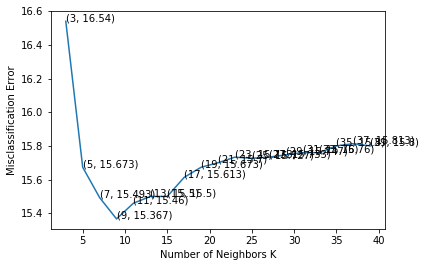

the misclassification error for each k value is :  [16.54  15.673 15.493 15.367 15.46  15.5   15.5   15.613 15.673 15.7
 15.733 15.727 15.733 15.747 15.76  15.76  15.8   15.813 15.8  ]


In [43]:
# knn using brute force technique to find optimal k using Simple cross validation
k = Simple_cv(X_tr,y_tr,Xcv,ycv,"brute")

In [44]:
savetofile(k,"k_Bow_BF")

In [45]:
filename = 'bow_bf.sav'
pickle.dump(Simple_cv, open(filename, 'wb'))

In [46]:
# knn using brute force technique to find accuracy
knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
knn.fit(X_tr,y_tr)
pred = knn.predict(Xt)
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %d%%' % (k,acc))


****Test accuracy for k = 9 is 84%


In [47]:
# Confusion matrix for bow using brute force
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yt, pred)
cm

array([[  135,  2246],
       [   74, 12545]], dtype=int64)

In [48]:
from sklearn.metrics import f1_score
f1_score(yt, pred, average='micro')

0.8453333333333333

In [60]:
# Reducing dimensions and converting sparse matrix to dense matrix using Truncated SVD
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, random_state=0)
X_tr = svd.fit_transform(X_tr)
Xt = svd.transform(Xt)
Xcv = svd.transform(Xcv)


The optimal number of neighbors is 27.


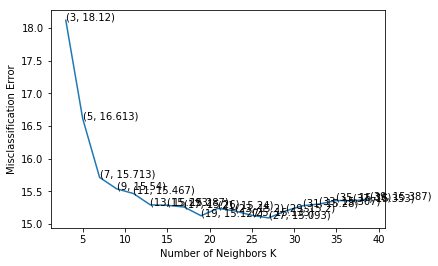

the misclassification error for each k value is :  [18.12  16.613 15.713 15.54  15.467 15.293 15.287 15.26  15.127 15.24
 15.2   15.133 15.093 15.2   15.28  15.307 15.36  15.353 15.387]


In [62]:
# knn using kd tree technique to find optimal k using Simple cross validation
k = Simple_cv(X_tr,y_tr,Xcv,ycv,'kd_tree')

In [63]:
savetofile(k,"k_Bow_kd")

In [64]:
filename = 'bow_kd.sav'
pickle.dump(Simple_cv, open(filename, 'wb'))

In [65]:
# knn using kd tree technique to find accuracy using optimal k
knn = KNeighborsClassifier(n_neighbors=k, algorithm = "kd_tree")
knn.fit(X_tr,y_tr)
pred = knn.predict(Xt)
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %d%%' % (k,acc))


****Test accuracy for k = 27 is 84%


In [66]:
# Confusion matrix for bow using kd tree
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yt, pred)
cm

array([[  210,  2171],
       [  113, 12506]], dtype=int64)

In [67]:
from sklearn.metrics import f1_score
f1_score(yt, pred, average='micro')

0.8477333333333333

<strong>Observations:</strong>
- Using BoW optimal K in KNN for Brute force is 9 having accuracy of 84 % and f1 score is 0.84533
- Using BoW optimal K in KNN for kd-tree is 27 having accuracy of 84 % and f1 score is 0.84773

<h3>TF-IDF</h3>

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()
X_tr = tf_idf_vect.fit_transform(X_tr)
Xcv = tf_idf_vect.transform(Xcv)
Xt = tf_idf_vect.transform(Xt)


The optimal number of neighbors is 13.


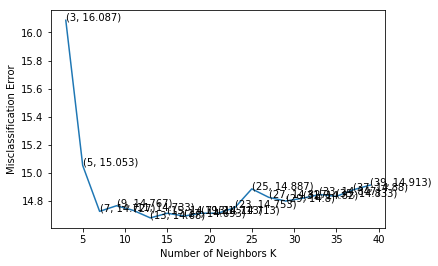

the misclassification error for each k value is :  [16.087 15.053 14.727 14.767 14.733 14.68  14.713 14.693 14.713 14.713
 14.753 14.887 14.827 14.8   14.82  14.847 14.833 14.88  14.913]


In [86]:
# knn using brute force technique to find optimal k using Simple cross validation
k = Simple_cv(X_tr,y_tr,Xcv,ycv,"brute")

In [87]:
savetofile(k,"k_tfidf_bf")

In [88]:
filename = 'tfidf_bf.sav'
pickle.dump(Simple_cv, open(filename, 'wb'))

In [89]:
# knn using brute force technique to find accuracy using optimal k
knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
knn.fit(X_tr,y_tr)
pred = knn.predict(Xt)
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %d%%' % (k,acc))


****Test accuracy for k = 13 is 85%


In [90]:
# Confusion matrix for bow using kd tree
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yt, pred)
cm

array([[  296,  2085],
       [   69, 12550]], dtype=int64)

In [91]:
from sklearn.metrics import f1_score
f1_score(yt, pred, average='micro')

0.8564

In [92]:
# Reducing dimensions and converting sparse matrix to dense matrix using Truncated SVD
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, random_state=0)
X_tr = svd.fit_transform(X_tr)
Xt = svd.transform(Xt)
Xcv = svd.transform(Xcv)


The optimal number of neighbors is 35.


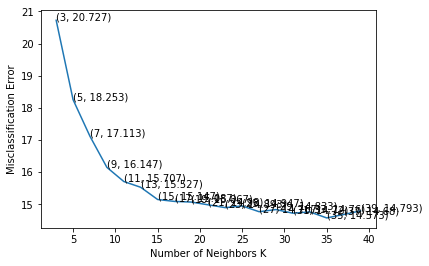

the misclassification error for each k value is :  [20.727 18.253 17.113 16.147 15.707 15.527 15.147 15.087 15.067 14.98
 14.893 14.947 14.767 14.833 14.72  14.76  14.573 14.68  14.793]


In [93]:
# knn using kd tree technique to find optimal k using Simple cross validation
k = Simple_cv(X_tr,y_tr,Xcv,ycv,'kd_tree')

In [94]:
# knn using kd tree technique to find accuracy using optimal k
knn = KNeighborsClassifier(n_neighbors=k, algorithm = "kd_tree")
knn.fit(X_tr,y_tr)
pred = knn.predict(Xt)
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %d%%' % (k,acc))


****Test accuracy for k = 35 is 85%


In [95]:
# Confusion matrix for bow using kd tree
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yt, pred)
cm

array([[  332,  2049],
       [  139, 12480]], dtype=int64)

In [96]:
from sklearn.metrics import f1_score
f1_score(yt, pred, average='micro')

0.8541333333333333

<strong>Observations:</strong>
- Using TF-IDF optimal K in KNN for Brute force is 13 having accuracy of 85 % and f1 score is 0.8564
- Using TF-IDF optimal K in KNN for kd-tree is 35 having accuracy of 85 % and f1 score is 0.85413

<h3>word2vec</h3>

In [18]:
# Trainning Word2Vec model using own text corpus
i=0
list_of_sent=[]
for sent in X_tr.values: 
    list_of_sent.append(sent.split())

In [19]:
# Trainning Word2Vec model using own CV corpus
i=0
list_of_sent_cv=[]
for sent in Xcv.values: 
    list_of_sent_cv.append(sent.split())

In [20]:
# Trainning Word2Vec model using own text corpus
i=0
list_of_sent_test=[]
for sent in Xt.values: 
    list_of_sent_test.append(sent.split())

In [21]:
# min_count = 5 considers only words that occured atleast 5 times
import warnings
warnings.filterwarnings("ignore")

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=3)
w2v_model_cv=Word2Vec(list_of_sent_cv,min_count=5,size=50, workers=3)
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=3)

In [22]:
savetofile(w2v_model,"train_w2v")
savetofile(w2v_model_cv,"cv_w2v")
savetofile(w2v_model_test,"test_w2v")

In [23]:
w2v_words = list(w2v_model.wv.vocab)
w2v_words_cv = list(w2v_model_cv.wv.vocab)
w2v_words_test = list(w2v_model_test.wv.vocab)

<h3>Average Word2Vec </h3>

In [165]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

30000
50


In [166]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_cv.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

15000
50


In [167]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

30000
50


In [168]:
X_tr = sent_vectors
Xcv = sent_vectors_cv
Xt = sent_vectors_test

In [173]:
X_tr = np.nan_to_num(X_tr)


The optimal number of neighbors is 15.


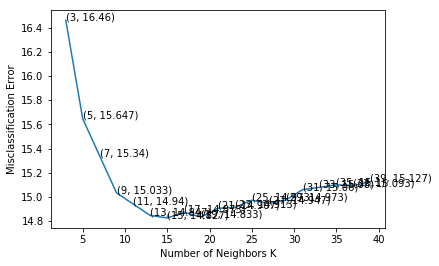

the misclassification error for each k value is :  [16.46  15.647 15.34  15.033 14.94  14.847 14.827 14.873 14.833 14.907
 14.913 14.973 14.947 14.973 15.06  15.08  15.1   15.093 15.127]


In [137]:
# knn using brute force technique to find optimal k using Simple cross validation
k = Simple_cv(X_tr,y_tr,Xcv,ycv,"brute")

In [174]:
Xt = np.nan_to_num(Xt)

In [139]:
# knn using kd tree technique to find accuracy using optimal k
knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
knn.fit(X_tr,y_tr)
pred = knn.predict(Xt)
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %d%%' % (k,acc))


****Test accuracy for k = 15 is 85%


In [140]:
# Confusion matrix for bow using kd tree
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yt, pred)
cm

array([[   97,  2162],
       [   51, 12690]], dtype=int64)

In [141]:
from sklearn.metrics import f1_score
f1_score(yt, pred, average='micro')

0.8524666666666667

In [178]:
Xcv = np.nan_to_num(Xcv)


The optimal number of neighbors is 11.


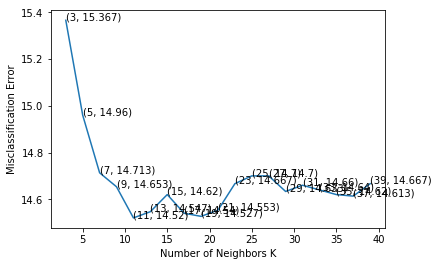

the misclassification error for each k value is :  [15.367 14.96  14.713 14.653 14.52  14.547 14.62  14.54  14.527 14.553
 14.667 14.7   14.7   14.633 14.66  14.64  14.62  14.613 14.667]


In [179]:
# knn using brute force technique to find optimal k using Simple cross validation
k = Simple_cv(X_tr,y_tr,Xcv,ycv,'kd_tree')

In [180]:
# knn using kd tree technique to find accuracy using optimal k
knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'kd_tree')
knn.fit(X_tr,y_tr)
pred = knn.predict(Xt)
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %d%%' % (k,acc))


****Test accuracy for k = 11 is 84%


In [181]:
# Confusion matrix for bow using kd tree
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yt, pred)
cm

array([[   75,  2304],
       [   32, 12589]], dtype=int64)

In [182]:
from sklearn.metrics import f1_score
f1_score(yt, pred, average='micro')

0.8442666666666667

<strong>Observations:</strong>
- Using avg word2vec optimal K in KNN for Brute force is 15 having accuracy of 85 % and f1 score is 0.85246
- Using avg word2vec optimal K in KNN for kd-tree is 11 having accuracy of 84 % and f1 score is 0.84426

<h3>Tf-Idf Word2Vec </h3>

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()
X_tr = tf_idf_vect.fit_transform(X_tr)
Xcv = tf_idf_vect.transform(Xcv)
Xt = tf_idf_vect.transform(Xt)

In [25]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

In [26]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_tr[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [27]:
X_train = tfidf_sent_vectors

In [28]:
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try :
            if word in w2v_words_cv:
                vec = w2v_model_cv.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = Xcv[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

In [29]:
X_cv = tfidf_sent_vectors_cv

In [30]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try :
            if word in w2v_words_test:
                vec = w2v_model_test.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = Xt[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [31]:
x_test = tfidf_sent_vectors_test

In [32]:
X_train = np.nan_to_num(X_train)
X_cv = np.nan_to_num(X_cv)
x_test = np.nan_to_num(x_test)


The optimal number of neighbors is 19.


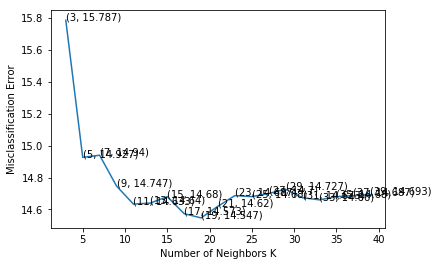

the misclassification error for each k value is :  [15.787 14.927 14.94  14.747 14.633 14.64  14.68  14.573 14.547 14.62
 14.687 14.68  14.7   14.727 14.673 14.66  14.68  14.687 14.693]


In [231]:
# knn using brute force technique to find optimal k using Simple cross validation
k = Simple_cv(X_train,y_tr,X_cv,ycv,"brute")

In [232]:
# knn using brute force technique to find accuracy using optimal k
knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
knn.fit(X_train,y_tr)
pred = knn.predict(x_test)
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %d%%' % (k,acc))


****Test accuracy for k = 19 is 84%


In [233]:
# Confusion matrix for bow using brute force
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yt, pred)
cm

array([[   71,  2308],
       [   18, 12603]], dtype=int64)

In [234]:
from sklearn.metrics import f1_score
f1_score(yt, pred, average='micro')

0.8449333333333333


The optimal number of neighbors is 33.


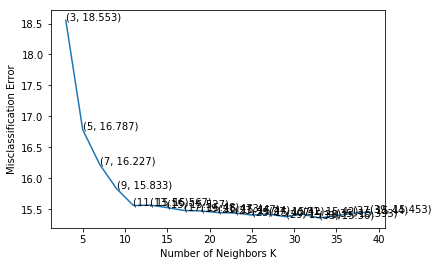

the misclassification error for each k value is :  [18.553 16.787 16.227 15.833 15.56  15.567 15.527 15.48  15.473 15.447
 15.44  15.407 15.42  15.38  15.42  15.36  15.393 15.44  15.453]


In [33]:
# knn using brute force technique to find optimal k using Simple cross validation
k = Simple_cv(X_train,y_tr,X_cv,ycv,'kd_tree')

In [34]:
# knn using kd tree technique to find accuracy using optimal k
knn = KNeighborsClassifier(n_neighbors=k, algorithm = "kd_tree")
knn.fit(X_train,y_tr)
pred = knn.predict(x_test)
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %d%%' % (k,acc))


****Test accuracy for k = 33 is 84%


In [35]:
# Confusion matrix for bow using kd tree
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yt, pred)
cm

array([[  346,  2035],
       [  313, 12306]], dtype=int64)

In [36]:
from sklearn.metrics import f1_score
f1_score(yt, pred, average='micro')

0.8434666666666667

<strong>Observations:</strong>
- Using tfidf word2vec optimal K in KNN for Brute force is 19 having accuracy of 84 % and f1 score is 0.8449
- Using tfidf word2vec optimal K in KNN for kd-tree is 33 having accuracy of 84 % and f1 score is 0.84346

<h3> CONCLUSION: </h3>

In [39]:
table = {'Technique':['KNN with Bow', "KNN with TFIDF", "KNN with Avg_w2v", "KNN with tfidf_w2v"],'K in Brute force':[9,13,15,19],'Accuracy in brute':[84,85,85,84],'F1 brute':[0.8453,0.8564,0.8524,0.8449] ,'K in kd tree':[27,35,11,33],'Accuracy in kd tree':[84,85,84,84],'F1 kd tree':[0.8477,0.8541,0.8442,0.8434]}
df = pd.DataFrame(data=table)
df

,Technique,K in Brute force,Accuracy in brute,F1 brute,K in kd tree,Accuracy in kd tree,F1 kd tree
0,KNN with Bow,9,84,0.8453,27,84,0.8477
1,KNN with TFIDF,13,85,0.8564,35,85,0.8541
2,KNN with Avg_w2v,15,85,0.8524,11,84,0.8442
3,KNN with tfidf_w2v,19,84,0.8449,33,84,0.8434


    -The kd-tree and brute implementation of KNN gives relatively similar results
    -As the dataset is highly imbalanced there is dominance of positive class in predecting query point
    -As kd-tree gives high K value it can be trusted over brute force but disadvatage is it takes a lot of time
    -Hence KNN with good performance can be applied on only small to medium range balanced data set